In [285]:
from dataclasses import dataclass
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
@dataclass
class Die:
    """
    Simple interface for rolling an n-sided die
    """
    n: int = 6

    def __call__(self) -> int:
        return randint(1, self.n)

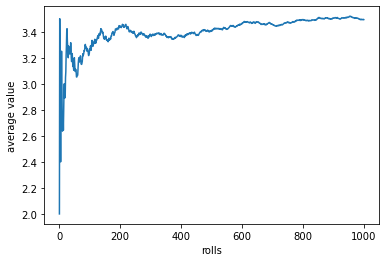

In [56]:
"""
Verify that the die works how we expect
"""
die = Die()

x = np.arange(1, 1001)
rolls = [die() for _ in x]

plt.plot(x, np.cumsum(rolls)/(x))
plt.xlabel("rolls")
plt.ylabel("average value")
plt.show()

We see our EV is, as expected, about 3.5.

In [53]:
@dataclass
class Dice:
    """
    Simple interface for a bunch of dice
    """
    dice: list[Die]

    def __call__(self) -> list[int]:
        """
        Returns three rolls in descending order
        """
        return sorted([die() for die in self.dice], reverse=True)

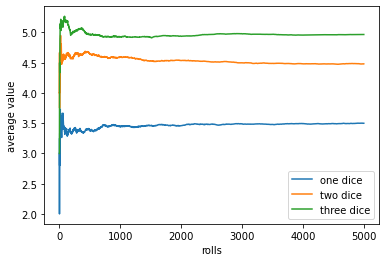

In [57]:
"""
Verify that rolling a bunch of dice and taking the highest
number works as we expect.
"""
two_dice = Dice([die, die])
three_dice = Dice([die, die, die])

x = np.arange(1, 5001)

one = [die() for _ in x]
two = [two_dice()[0] for _ in x]
three = [three_dice()[0] for _ in x]

plt.plot(x, np.cumsum(one)/(x), label="one dice")
plt.plot(x, np.cumsum(two)/(x), label="two dice")
plt.plot(x, np.cumsum(three)/(x), label="three dice")
plt.legend()
plt.xlabel("rolls")
plt.ylabel("average value")
plt.show()

We see our EV's follow the expected pattern, 5 for 3 dice, 4.5 for 2 dice, 3.5 for 1 die.

In [201]:
@dataclass
class Battle:
    """
    Battle two sets of dice and give the outcome for each matched pair of dice
    (attacker vs defender), True if attacker gets the kill and False if attacker
    is killed.
    """
    attackers: Dice
    defenders: Dice

    def __post_init__(self):
        self.n_kills = min(len(self.attackers.dice), len(self.defenders.dice))

    def __call__(self) -> list[bool]:
        return [
            attacker > defender
            for attacker, defender in zip(
                self.attackers(), self.defenders()
            )
        ][:self.n_kills]

Text(0.5, 0, 'Battles')

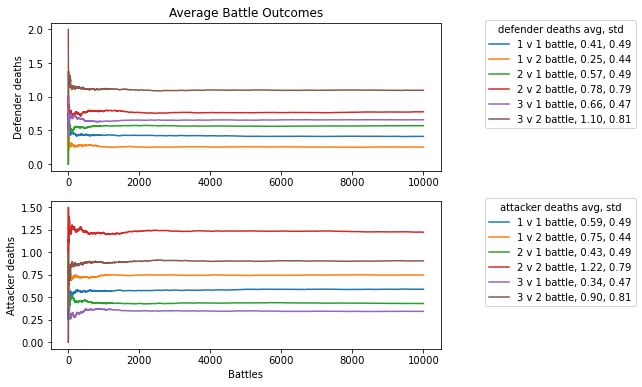

In [191]:
x = np.arange(1, 10001)
fig, [def_ax, atk_ax] = plt.subplots(2, figsize=(7, 6))

for n_atk in range(1, 4):
    for n_def in range(1, 3):
        battle = Battle(Dice([die] * n_atk), Dice([die] * n_def))
        n_kills = min(n_atk, n_def)
        def_deaths = [sum(battle()) for _ in x]
        atk_deaths = [n_kills - def_death for def_death in def_deaths]
        def_ax.plot(
            x,
            np.cumsum(def_deaths)/(x),
            label=f"{n_atk} v {n_def} battle, {np.mean(def_deaths):.2f}, {np.std(def_deaths):.2f}"
        )
        atk_ax.plot(
            x,
            np.cumsum(atk_deaths)/(x),
            label=f"{n_atk} v {n_def} battle, {np.mean(atk_deaths):.2f}, {np.std(atk_deaths):.2f}"
        )

def_ax.set_title("Average Battle Outcomes")
atk_ax.legend(bbox_to_anchor=(1.1, 1.05), title="attacker deaths avg, std")
def_ax.legend(bbox_to_anchor=(1.1, 1.05), title="defender deaths avg, std")
atk_ax.set_ylabel("Attacker deaths")
def_ax.set_ylabel("Defender deaths")
atk_ax.set_xlabel("Battles")

Here we see the outcome for each kind of battle possible in the game. The numbers generally make sense and scale in reasonable ways.

    1 v 1: defender is favored by ~1/6, i.e. tie advantage
    2 v 1: defender gets the kill 43% of the time
    2 v 2: defender advantage is higher than it is in 1 v 1
    3 v 1: clutch factor, defender still wins 1/3 the time
    3 v 2: kind of the big point to make here, attacker is slightly favored

In [367]:
@dataclass
class StandardWarOfAttrition:
    """
    Attacker begins a war of attrition with some number of units. Staging for
    the battle is reset after each battle, following the standard rules.
    """
    attacker_units: int
    defender_units: int

    def __post_init__(self):
        self.battle_dict = {}
        for a in range(1, 4):
            for b in range(1, 3):
                self.battle_dict[f"{a}{b}"] = Battle(
                    Dice([die] * a),
                    Dice([die] * b)
                )

    def __call__(self):
        remaining_attackers = self.attacker_units
        remaining_defenders = self.defender_units
        while remaining_attackers and remaining_defenders:
            battle = self.battle_dict[
                f"{min(3, remaining_attackers)}{min(2, remaining_defenders)}"
            ]()
            remaining_defenders -= sum(battle)
            remaining_attackers -= len(battle) - sum(battle)
        return (
            self.attacker_units - remaining_attackers,
            self.defender_units - remaining_defenders,
            remaining_attackers > 0
        )   

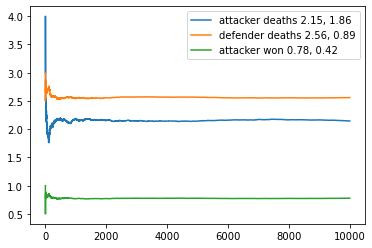

In [368]:
five_v_three = StandardWarOfAttrition(5, 3)

x = np.arange(1, 10000)
outcomes = [five_v_three() for _ in x]
atk_deaths = [out[0] for out in outcomes]
def_deaths = [out[1] for out in outcomes]
atk_won = [out[2] for out in outcomes]
plt.plot(
    x,
    np.cumsum(atk_deaths)/(x),
    label=f"attacker deaths {np.mean(atk_deaths):.2f}, {np.std(atk_deaths):.2f}"
)
plt.plot(
    x,
    np.cumsum(def_deaths)/(x),
    label=f"defender deaths {np.mean(def_deaths):.2f}, {np.std(def_deaths):.2f}"
)
plt.plot(
    x,
    np.cumsum(atk_won)/(x),
    label=f"attacker won {np.mean(atk_won):.2f}, {np.std(atk_won):.2f}"
)
plt.legend()
plt.show()

Here we get the first look at what happens on average in wars of attrition, using the standard rules. In a 5 vs 3, the attacker usually wins, whaddya know! EV is 0.77, 77% chance of a win. That said, the standard deviation is %42!! Huge!

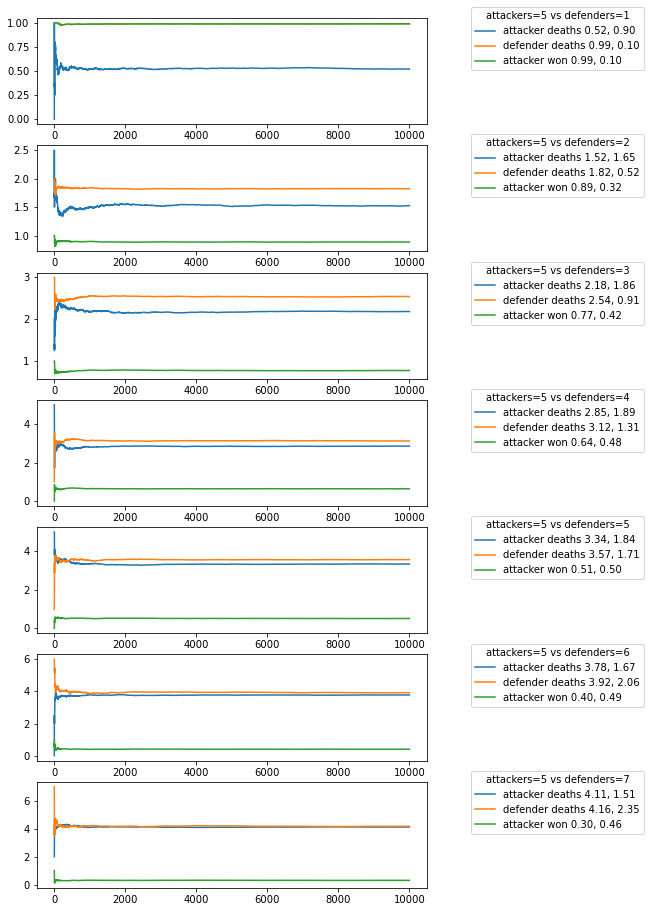

In [370]:
defenders = 7
fig, axs = plt.subplots(defenders, figsize=(7, 16))
for defenders, ax in zip(range(1, defenders + 1), axs):
    five_v_x = StandardWarOfAttrition(5, defenders)

    x = np.arange(1, 10000)
    outcomes = [five_v_x() for _ in x]
    atk_deaths = [out[0] for out in outcomes]
    def_deaths = [out[1] for out in outcomes]
    atk_won = [out[2] for out in outcomes]
    ax.plot(
        x,
        np.cumsum(atk_deaths)/(x),
        label=f"attacker deaths {np.mean(atk_deaths):.2f}, {np.std(atk_deaths):.2f}"
    )
    ax.plot(
        x,
        np.cumsum(def_deaths)/(x),
        label=f"defender deaths {np.mean(def_deaths):.2f}, {np.std(def_deaths):.2f}"
    )
    ax.plot(
        x,
        np.cumsum(atk_won)/(x),
        label=f"attacker won {np.mean(atk_won):.2f}, {np.std(atk_won):.2f}"
    )
    ax.legend(bbox_to_anchor=(1.1, 1.15), title=f"attackers=5 vs {defenders=}")
plt.show()

Here we're looking for the expected outcome with 5 attackers and n defenders, going from 1 to 7. To make sure things make sense and add up, let's look at the first plot briefly. The plot claims that on average, in a 5 v 1, ~0.54 attackers die. However, in a 3 v 1 (the first battle in the war of attrition), we can reference above and find that 0.34 attackers die? What gives?

Well, 
$$0.58 \approx 0.34 + 0.34 \cdot 0.43 + 0.34 \cdot 0.45 \cdot 0.41 + 0.34 \cdot 0.45 \cdot 0.41 \cdot 0.41 $$

if we add the chances that the *next* battle results in one attacker death, on and on, where one attacker dies 43% of the time in a 2 v 1 and 41% of the time in a 1 v 1. Considering the standard deviation is ~0.54 attackers die, +/- 0.9 attackers, the outcome is relatively close.

Further notes, obviously the chance that the attacker wins goes down each time you add a defender, usually by around 11% per defender. We can see in the 5 v 5 that the attacker is favored slightly, but variance is very high.

In a 5 v 7 we see that the same number of attackers and defenders die on average, even though the defenders still win 3/10 of the time.

In [339]:
@dataclass
class TableWarOfAttrition:
    """
    Attacker begins a war of attrition with some number of units. Staging for
    the battle is only reset after either staged party is wiped, following odd
    table rules.
    """
    attacker_units: int
    defender_units: int

    def __post_init__(self):
        self.battle_dict = {}
        for a in range(1, 4):
            for b in range(1, 3):
                self.battle_dict[f"{a}{b}"] = Battle(
                    Dice([die] * a),
                    Dice([die] * b)
                )

    def __call__(self):
        remaining_attackers = self.attacker_units
        remaining_defenders = self.defender_units
        while remaining_attackers and remaining_defenders:
            staged_attackers = min(3, remaining_attackers)
            staged_defenders = min(2, remaining_defenders)
            while staged_attackers and staged_defenders:
                battle = self.battle_dict[
                    f"{staged_attackers}{staged_defenders}"
                ]()
                remaining_defenders -= sum(battle)
                remaining_attackers -= len(battle) - sum(battle)
                staged_defenders -= sum(battle)
                staged_attackers -= len(battle) - sum(battle)
        return (
            self.attacker_units - remaining_attackers,
            self.defender_units - remaining_defenders,
            remaining_attackers > 0
        )

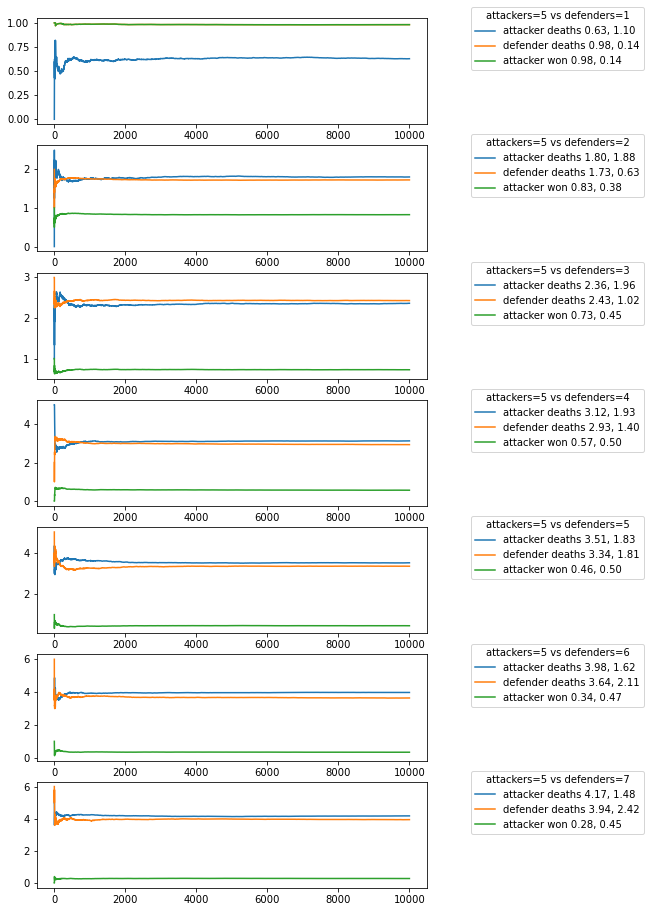

In [371]:
defenders = 7
fig, axs = plt.subplots(defenders, figsize=(7, 16))
for defenders, ax in zip(range(1, defenders + 1), axs):
    five_v_x = TableWarOfAttrition(5, defenders)

    x = np.arange(1, 10000)
    outcomes = [five_v_x() for _ in x]
    atk_deaths = [out[0] for out in outcomes]
    def_deaths = [out[1] for out in outcomes]
    atk_won = [out[2] for out in outcomes]
    ax.plot(
        x,
        np.cumsum(atk_deaths)/(x),
        label=f"attacker deaths {np.mean(atk_deaths):.2f}, {np.std(atk_deaths):.2f}"
    )
    ax.plot(
        x,
        np.cumsum(def_deaths)/(x),
        label=f"defender deaths {np.mean(def_deaths):.2f}, {np.std(def_deaths):.2f}"
    )
    ax.plot(
        x,
        np.cumsum(atk_won)/(x),
        label=f"attacker won {np.mean(atk_won):.2f}, {np.std(atk_won):.2f}"
    )
    ax.legend(bbox_to_anchor=(1.1, 1.15), title=f"attackers=5 vs {defenders=}")
plt.show()

We can see that things changed, but it's hard to compare. Lets look more closely at how these six values - attacker deaths and variance, defender deaths and variance, attacker won and variance - change when you go from standard to table rules.

In [300]:
@dataclass
class AttritionEvaluator:
    n_iterations: int

    def __call__(
        self,
        war_of_attrition: StandardWarOfAttrition | TableWarOfAttrition
    ):
        return [war_of_attrition() for _ in range(self.n_iterations)]

In [381]:
evaluator = AttritionEvaluator(50000)

standard_results = pd.DataFrame(
    {
        attackers: {
            defenders: evaluator(StandardWarOfAttrition(attackers, defenders))
            for defenders in range(1, 13)}
        for attackers in range(1, 13)
    },
)
table_results = pd.DataFrame(
    {
        attackers: {
            defenders: evaluator(TableWarOfAttrition(attackers, defenders))
            for defenders in range(1, 13)}
        for attackers in range(1, 13)
    },
)

In [382]:
table_results.axes[1].name = "attackers"
table_results.axes[0].name = "defenders"
standard_results.axes[1].name = "attackers"
standard_results.axes[0].name = "defenders"

In [383]:
def attacker_deaths_mean(outcomes):
    return np.mean([out[0] for out in outcomes])

def attacker_deaths_std(outcomes):
    return np.std([out[0] for out in outcomes])

def defender_deaths_mean(outcomes):
    return np.mean([out[1] for out in outcomes])

def defender_deaths_std(outcomes):
    return np.std([out[1] for out in outcomes])

def attacker_wins_mean(outcomes):
    return np.mean([out[2] for out in outcomes]) * 100

def attacker_wins_std(outcomes):
    return np.std([out[2] for out in outcomes]) * 100

In [387]:
def make_pretty(styler):
    styler.background_gradient(axis=None, cmap="YlGnBu")
    styler.format(precision=2)
    return styler

for func in [
    attacker_deaths_mean,
    attacker_deaths_std,
    defender_deaths_mean,
    defender_deaths_std,
    attacker_wins_mean,
    attacker_wins_std,
]:
    print(f"{func.__name__}, standard")
    func_standard = standard_results.applymap(func)
    func_table = table_results.applymap(func)
    display(func_standard.style.pipe(make_pretty))
    print(f"{func.__name__}, table")
    display(func_table.style.pipe(make_pretty))
    print(f"{func.__name__}, difference")
    display((func_table-func_standard).style.pipe(make_pretty))

attacker_deaths_mean, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.59,0.67,0.57,0.54,0.52,0.53,0.52,0.53,0.52,0.51,0.52,0.52
2,0.89,1.41,1.41,1.54,1.50,1.55,1.53,1.55,1.54,1.56,1.54,1.56
3,0.97,1.67,1.88,2.08,2.18,2.24,2.26,2.28,2.31,2.29,2.30,2.29
4,0.99,1.86,2.29,2.67,2.84,3.01,3.06,3.15,3.17,3.21,3.21,3.19
5,1.00,1.92,2.54,3.02,3.37,3.59,3.75,3.86,3.91,3.95,4.02,3.99
6,1.00,1.97,2.72,3.35,3.79,4.16,4.38,4.56,4.64,4.74,4.80,4.85
7,1.00,1.98,2.82,3.53,4.13,4.57,4.92,5.16,5.36,5.48,5.59,5.65
8,1.00,1.99,2.88,3.69,4.35,4.92,5.36,5.70,5.95,6.14,6.29,6.40
9,1.00,2.00,2.93,3.78,4.55,5.19,5.72,6.13,6.51,6.75,6.95,7.12


attacker_deaths_mean, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.58,0.66,0.57,0.62,0.63,0.61,0.62,0.61,0.61,0.63,0.62,0.62
2,0.90,1.41,1.42,1.67,1.79,1.78,1.85,1.88,1.86,1.87,1.89,1.90
3,0.96,1.64,1.79,2.11,2.33,2.37,2.49,2.55,2.58,2.59,2.59,2.62
4,0.99,1.85,2.28,2.76,3.14,3.28,3.48,3.58,3.66,3.73,3.75,3.77
5,1.00,1.91,2.49,3.04,3.50,3.76,4.01,4.22,4.31,4.43,4.48,4.52
6,1.00,1.97,2.71,3.39,3.98,4.39,4.75,5.03,5.20,5.34,5.47,5.53
7,1.00,1.98,2.78,3.54,4.21,4.71,5.12,5.50,5.76,5.98,6.15,6.27
8,1.00,1.99,2.88,3.71,4.48,5.09,5.63,6.10,6.46,6.71,6.97,7.17
9,1.00,2.00,2.92,3.78,4.60,5.29,5.91,6.45,6.86,7.27,7.53,7.80


attacker_deaths_mean, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,-0.00,-0.01,-0.00,0.09,0.11,0.08,0.10,0.08,0.09,0.12,0.10,0.10
2,0.00,0.01,0.01,0.13,0.29,0.23,0.31,0.33,0.32,0.31,0.35,0.34
3,-0.02,-0.02,-0.09,0.04,0.15,0.14,0.23,0.27,0.27,0.29,0.28,0.33
4,-0.00,-0.01,-0.01,0.09,0.30,0.27,0.42,0.44,0.50,0.52,0.54,0.58
5,-0.00,-0.01,-0.05,0.02,0.13,0.17,0.26,0.36,0.40,0.48,0.45,0.54
6,-0.00,0.00,-0.01,0.04,0.19,0.24,0.36,0.47,0.56,0.60,0.67,0.68
7,-0.00,-0.00,-0.03,0.00,0.07,0.15,0.21,0.34,0.39,0.50,0.56,0.62
8,-0.00,0.00,0.00,0.02,0.12,0.18,0.28,0.40,0.50,0.57,0.67,0.77
9,-0.00,-0.00,-0.01,-0.00,0.05,0.10,0.19,0.32,0.35,0.51,0.58,0.69


attacker_deaths_std, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.49,0.85,0.94,0.93,0.90,0.90,0.89,0.90,0.90,0.88,0.88,0.88
2,0.31,0.84,1.29,1.55,1.63,1.73,1.75,1.80,1.79,1.82,1.80,1.82
3,0.16,0.69,1.29,1.63,1.87,2.03,2.13,2.20,2.25,2.25,2.28,2.27
4,0.08,0.47,1.13,1.56,1.88,2.15,2.31,2.46,2.54,2.62,2.65,2.67
5,0.04,0.37,0.97,1.44,1.83,2.15,2.41,2.60,2.76,2.83,2.95,2.97
6,0.02,0.24,0.78,1.23,1.67,2.05,2.37,2.64,2.83,2.99,3.11,3.21
7,0.01,0.18,0.65,1.07,1.49,1.91,2.27,2.59,2.86,3.05,3.24,3.35
8,0.00,0.12,0.52,0.89,1.31,1.72,2.12,2.47,2.79,3.06,3.25,3.45
9,0.00,0.09,0.41,0.75,1.13,1.53,1.94,2.33,2.67,2.97,3.24,3.47


attacker_deaths_std, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.49,0.84,0.94,1.08,1.11,1.09,1.11,1.11,1.11,1.13,1.12,1.12
2,0.31,0.83,1.29,1.65,1.87,1.92,2.07,2.14,2.15,2.19,2.23,2.23
3,0.20,0.70,1.27,1.65,1.96,2.10,2.31,2.45,2.50,2.57,2.63,2.64
4,0.11,0.48,1.13,1.56,1.94,2.19,2.47,2.67,2.80,2.93,3.01,3.07
5,0.07,0.37,0.99,1.43,1.84,2.17,2.48,2.76,2.94,3.11,3.25,3.35
6,0.04,0.23,0.79,1.20,1.61,1.99,2.36,2.68,2.94,3.17,3.36,3.51
7,0.02,0.19,0.68,1.07,1.46,1.87,2.26,2.61,2.92,3.20,3.44,3.63
8,0.01,0.11,0.51,0.86,1.22,1.62,2.01,2.39,2.75,3.06,3.36,3.60
9,0.01,0.08,0.43,0.75,1.08,1.47,1.86,2.24,2.63,2.96,3.29,3.57


attacker_deaths_std, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.00,-0.00,0.00,0.15,0.21,0.19,0.22,0.21,0.21,0.26,0.24,0.24
2,-0.01,-0.01,0.00,0.10,0.24,0.18,0.33,0.35,0.37,0.38,0.43,0.41
3,0.04,0.01,-0.02,0.02,0.09,0.08,0.18,0.25,0.25,0.32,0.35,0.37
4,0.03,0.01,-0.00,0.00,0.05,0.04,0.15,0.21,0.27,0.32,0.36,0.41
5,0.02,0.01,0.02,-0.01,0.01,0.02,0.07,0.16,0.17,0.28,0.31,0.38
6,0.02,-0.00,0.01,-0.02,-0.05,-0.05,-0.00,0.04,0.11,0.18,0.26,0.29
7,0.01,0.01,0.03,-0.01,-0.03,-0.04,-0.01,0.02,0.06,0.14,0.20,0.29
8,0.00,-0.01,-0.01,-0.02,-0.09,-0.09,-0.11,-0.08,-0.04,0.01,0.11,0.16
9,0.01,-0.00,0.02,0.00,-0.05,-0.06,-0.09,-0.09,-0.04,-0.02,0.05,0.11


defender_deaths_mean, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.41,0.75,0.91,0.97,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,0.37,0.92,1.44,1.65,1.83,1.90,1.95,1.97,1.99,1.99,2.00,2.00
3,0.35,1.06,1.82,2.24,2.54,2.72,2.83,2.90,2.94,2.97,2.98,2.99
4,0.35,1.10,2.07,2.62,3.12,3.41,3.63,3.75,3.85,3.90,3.94,3.96
5,0.34,1.14,2.23,2.94,3.55,4.00,4.32,4.54,4.70,4.81,4.87,4.92
6,0.34,1.14,2.32,3.12,3.91,4.45,4.91,5.23,5.49,5.65,5.76,5.84
7,0.34,1.15,2.39,3.28,4.13,4.84,5.39,5.82,6.15,6.41,6.58,6.71
8,0.34,1.16,2.45,3.39,4.37,5.13,5.79,6.34,6.77,7.10,7.35,7.54
9,0.35,1.15,2.45,3.47,4.47,5.35,6.12,6.77,7.29,7.71,8.05,8.29


defender_deaths_mean, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.42,0.76,0.91,0.95,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00
2,0.36,0.91,1.43,1.57,1.73,1.87,1.90,1.94,1.97,1.98,1.99,1.99
3,0.40,1.14,1.97,2.18,2.44,2.69,2.76,2.84,2.91,2.94,2.96,2.98
4,0.40,1.17,2.19,2.52,2.91,3.34,3.48,3.65,3.78,3.84,3.89,3.93
5,0.40,1.23,2.43,2.86,3.35,3.91,4.15,4.37,4.59,4.70,4.78,4.86
6,0.40,1.23,2.51,3.02,3.64,4.33,4.66,4.97,5.30,5.47,5.61,5.73
7,0.40,1.26,2.62,3.23,3.89,4.68,5.16,5.54,5.94,6.17,6.37,6.56
8,0.40,1.24,2.65,3.31,4.04,4.94,5.47,5.95,6.46,6.80,7.06,7.30
9,0.40,1.26,2.70,3.42,4.19,5.16,5.76,6.33,6.93,7.32,7.67,7.99


defender_deaths_mean, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.00,0.00,-0.00,-0.02,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
2,-0.01,-0.00,-0.00,-0.08,-0.10,-0.03,-0.05,-0.03,-0.02,-0.01,-0.01,-0.00
3,0.06,0.08,0.15,-0.06,-0.10,-0.02,-0.07,-0.06,-0.03,-0.03,-0.02,-0.01
4,0.05,0.07,0.12,-0.10,-0.21,-0.07,-0.15,-0.10,-0.07,-0.07,-0.05,-0.03
5,0.06,0.09,0.20,-0.08,-0.20,-0.09,-0.17,-0.18,-0.10,-0.11,-0.09,-0.06
6,0.06,0.09,0.19,-0.10,-0.27,-0.12,-0.24,-0.25,-0.19,-0.18,-0.15,-0.10
7,0.06,0.11,0.23,-0.06,-0.25,-0.16,-0.23,-0.28,-0.22,-0.24,-0.21,-0.15
8,0.06,0.08,0.19,-0.07,-0.33,-0.20,-0.32,-0.39,-0.31,-0.30,-0.29,-0.24
9,0.06,0.11,0.25,-0.05,-0.29,-0.19,-0.36,-0.44,-0.35,-0.39,-0.37,-0.30


defender_deaths_std, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.49,0.43,0.28,0.17,0.10,0.06,0.03,0.02,0.01,0.01,0.00,0.00
2,0.67,0.90,0.83,0.70,0.52,0.41,0.29,0.23,0.15,0.13,0.08,0.07
3,0.68,1.17,1.24,1.12,0.91,0.75,0.58,0.46,0.35,0.26,0.21,0.15
4,0.68,1.28,1.56,1.51,1.31,1.13,0.92,0.76,0.59,0.47,0.37,0.29
5,0.68,1.38,1.80,1.85,1.71,1.52,1.28,1.09,0.89,0.72,0.59,0.46
6,0.68,1.42,1.98,2.12,2.05,1.90,1.68,1.45,1.21,1.01,0.84,0.68
7,0.68,1.45,2.12,2.36,2.35,2.25,2.06,1.85,1.59,1.36,1.14,0.96
8,0.67,1.46,2.24,2.54,2.62,2.58,2.43,2.20,1.95,1.71,1.47,1.25
9,0.68,1.46,2.28,2.68,2.83,2.86,2.75,2.58,2.33,2.09,1.82,1.59


defender_deaths_std, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.49,0.43,0.28,0.22,0.14,0.08,0.06,0.04,0.02,0.02,0.01,0.01
2,0.66,0.90,0.83,0.76,0.63,0.46,0.41,0.31,0.22,0.19,0.15,0.11
3,0.79,1.21,1.23,1.17,1.01,0.78,0.70,0.57,0.42,0.37,0.29,0.21
4,0.79,1.32,1.54,1.54,1.41,1.16,1.07,0.89,0.70,0.62,0.51,0.38
5,0.81,1.46,1.85,1.90,1.80,1.56,1.45,1.27,1.02,0.90,0.77,0.61
6,0.82,1.48,2.01,2.16,2.11,1.92,1.82,1.65,1.38,1.24,1.06,0.87
7,0.81,1.54,2.22,2.42,2.42,2.28,2.19,2.02,1.75,1.60,1.41,1.17
8,0.82,1.53,2.28,2.58,2.64,2.56,2.54,2.39,2.13,1.96,1.76,1.51
9,0.82,1.56,2.39,2.75,2.87,2.84,2.86,2.73,2.49,2.34,2.14,1.86


defender_deaths_std, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.00,-0.00,0.00,0.05,0.04,0.02,0.03,0.02,0.01,0.01,0.01,0.01
2,-0.01,-0.00,0.00,0.05,0.11,0.05,0.11,0.08,0.07,0.06,0.07,0.04
3,0.11,0.04,-0.01,0.05,0.09,0.03,0.12,0.11,0.08,0.10,0.08,0.06
4,0.11,0.04,-0.02,0.03,0.09,0.04,0.15,0.13,0.11,0.15,0.14,0.10
5,0.13,0.08,0.05,0.05,0.09,0.04,0.17,0.18,0.13,0.18,0.18,0.15
6,0.14,0.06,0.03,0.03,0.06,0.02,0.14,0.20,0.17,0.23,0.22,0.19
7,0.14,0.10,0.10,0.06,0.07,0.02,0.13,0.17,0.17,0.24,0.27,0.21
8,0.15,0.08,0.04,0.04,0.01,-0.01,0.12,0.19,0.17,0.25,0.29,0.26
9,0.13,0.10,0.10,0.07,0.04,-0.02,0.11,0.16,0.16,0.25,0.32,0.27


attacker_wins_mean, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,41.24,75.33,91.49,97.12,99.02,99.63,99.88,99.95,99.99,99.99,100.00,100.00
2,10.91,36.39,65.59,78.23,89.06,93.44,96.70,97.98,99.06,99.36,99.71,99.83
3,2.66,20.54,47.04,64.16,77.13,85.62,91.16,94.50,96.68,98.16,98.86,99.40
4,0.66,9.03,31.59,47.44,64.13,74.49,83.52,88.67,93.01,95.34,97.17,98.23
5,0.18,5.00,20.45,35.81,50.41,63.85,73.89,81.79,87.25,91.70,94.19,96.51
6,0.03,2.19,13.13,24.70,39.62,51.80,63.86,72.87,81.28,86.33,90.53,93.27
7,0.01,1.13,8.36,18.25,29.38,42.26,53.64,64.08,72.39,80.04,85.07,89.60
8,0.00,0.53,5.51,12.44,22.60,33.33,44.56,55.00,64.51,72.48,79.34,84.48
9,0.00,0.26,3.28,8.81,16.29,25.79,36.02,46.83,55.62,65.11,72.62,78.65


attacker_wins_mean, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,41.62,75.68,91.48,95.08,97.94,99.30,99.61,99.81,99.95,99.96,99.98,99.99
2,10.50,36.09,65.32,73.29,83.05,91.45,93.41,96.04,98.07,98.53,99.07,99.57
3,4.38,22.62,52.76,62.61,72.90,84.26,87.86,91.61,95.27,96.55,97.71,98.74
4,1.14,9.69,32.70,44.05,55.76,70.53,77.23,83.86,89.42,92.26,94.68,96.63
5,0.45,5.76,24.24,35.34,46.27,60.57,69.13,75.77,83.24,87.40,90.71,93.68
6,0.13,2.21,13.89,23.32,33.64,47.17,56.91,65.44,74.33,80.22,85.00,89.42
7,0.04,1.44,10.46,18.45,26.65,38.46,49.02,57.26,66.46,73.11,78.88,84.15
8,0.01,0.53,5.59,11.68,18.43,28.76,38.46,47.14,56.45,65.07,71.31,77.35
9,0.01,0.33,3.97,8.95,14.58,22.98,31.47,39.48,48.79,56.85,64.29,70.73


attacker_wins_mean, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.38,0.35,-0.02,-2.04,-1.09,-0.33,-0.27,-0.15,-0.04,-0.03,-0.02,-0.01
2,-0.41,-0.30,-0.28,-4.95,-6.01,-1.98,-3.30,-1.94,-0.99,-0.84,-0.63,-0.26
3,1.72,2.09,5.72,-1.55,-4.23,-1.37,-3.30,-2.89,-1.41,-1.61,-1.15,-0.66
4,0.48,0.66,1.11,-3.38,-8.37,-3.95,-6.28,-4.81,-3.59,-3.09,-2.49,-1.61
5,0.27,0.76,3.78,-0.47,-4.15,-3.28,-4.76,-6.03,-4.01,-4.30,-3.48,-2.83
6,0.10,0.02,0.75,-1.37,-5.98,-4.63,-6.95,-7.43,-6.95,-6.11,-5.53,-3.85
7,0.04,0.31,2.10,0.20,-2.73,-3.80,-4.62,-6.83,-5.93,-6.93,-6.19,-5.45
8,0.00,-0.00,0.08,-0.76,-4.17,-4.57,-6.10,-7.86,-8.06,-7.41,-8.02,-7.13
9,0.01,0.07,0.69,0.14,-1.71,-2.81,-4.55,-7.35,-6.82,-8.25,-8.33,-7.92


attacker_wins_std, standard


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,49.23,43.11,27.90,16.74,9.83,6.06,3.40,2.19,1.18,0.77,0.00,0.00
2,31.18,48.11,47.51,41.27,31.22,24.76,17.85,14.08,9.63,7.95,5.40,4.17
3,16.10,40.40,49.91,47.95,42.00,35.08,28.38,22.79,17.92,13.45,10.61,7.75
4,8.11,28.66,46.49,49.93,47.96,43.59,37.10,31.69,25.50,21.07,16.59,13.17
5,4.22,21.79,40.34,47.94,50.00,48.04,43.93,38.59,33.35,27.59,23.39,18.36
6,1.84,14.64,33.78,43.13,48.91,49.97,48.04,44.46,39.01,34.35,29.29,25.06
7,0.77,10.56,27.68,38.62,45.55,49.40,49.87,47.98,44.71,39.97,35.64,30.52
8,0.45,7.29,22.81,33.01,41.82,47.14,49.70,49.75,47.85,44.66,40.49,36.21
9,0.00,5.13,17.80,28.34,36.92,43.75,48.01,49.90,49.68,47.66,44.59,40.98


attacker_wins_std, table


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,49.29,42.90,27.92,21.63,14.21,8.34,6.22,4.40,2.24,1.90,1.34,0.77
2,30.66,48.03,47.60,44.25,37.52,27.96,24.82,19.51,13.75,12.05,9.58,6.56
3,20.46,41.84,49.92,48.38,44.45,36.42,32.66,27.73,21.24,18.25,14.96,11.15
4,10.63,29.58,46.91,49.65,49.67,45.59,41.93,36.79,30.76,26.73,22.45,18.06
5,6.66,23.30,42.85,47.80,49.86,48.87,46.20,42.85,37.35,33.18,29.02,24.34
6,3.63,14.71,34.58,42.29,47.25,49.92,49.52,47.56,43.68,39.84,35.71,30.76
7,2.05,11.91,30.60,38.79,44.21,48.65,49.99,49.47,47.21,44.34,40.82,36.52
8,0.77,7.26,22.97,32.12,38.77,45.26,48.65,49.92,49.58,47.68,45.23,41.86
9,0.77,5.77,19.53,28.54,35.29,42.07,46.44,48.88,49.99,49.53,47.92,45.50


attacker_wins_std, difference


attackers,1,2,3,4,5,6,7,8,9,10,11,12
defenders,,,,,,,,,,,,
1,0.07,-0.21,0.03,4.90,4.38,2.28,2.81,2.21,1.05,1.12,1.34,0.77
2,-0.52,-0.09,0.09,2.98,6.30,3.19,6.96,5.43,4.12,4.10,4.18,2.39
3,4.36,1.44,0.01,0.43,2.45,1.34,4.28,4.93,3.32,4.80,4.35,3.41
4,2.53,0.92,0.43,-0.29,1.71,2.00,4.83,5.10,5.25,5.66,5.85,4.88
5,2.45,1.51,2.51,-0.14,-0.14,0.83,2.27,4.26,4.00,5.60,5.63,5.98
6,1.79,0.08,0.80,-0.84,-1.66,-0.05,1.48,3.09,4.67,5.48,6.42,5.70
7,1.27,1.34,2.92,0.17,-1.34,-0.75,0.12,1.49,2.51,4.37,5.18,6.00
8,0.33,-0.03,0.16,-0.89,-3.05,-1.88,-1.05,0.17,1.73,3.02,4.74,5.65
9,0.77,0.64,1.72,0.20,-1.64,-1.68,-1.57,-1.02,0.30,1.86,3.32,4.52


Lots there. Lets talk about the very last table, so the one right above this text. This shows the difference in the variance of the attacker winning when you go from standard rules to table rules. My takeaways are:

2. Slightly lower variance in larger battles when the attacker is outnumbered by a a little (middle/bottom triangle)
3. Much higher variance when the defender is outnumbered (top/right)
4. Very little change when the battle is even
5. Higher variance when there are fewer attackers (left side)


The other one to talk about is the percentage chance that the attacker wins, which is the fourth plot from the bottom. This shows that the table rules are just a straight debuff for the attacker, which gets worse the more defenders there are.